In [153]:
import pandas as pd
import numpy as np
import scipy as sc
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as matplotlib 
import math
from statsmodels.tsa.stattools import adfuller
from scipy import stats

Read Gold (D1) data:

In [154]:
df=pd.read_csv('quotes/XAUUSD.csv') 
df.columns=['date','time','open','high','low','close','volume'] 
df=df[['date','open','close','low','high']]
df.set_index('date',inplace=True)
df=df.drop(['high','low','open'], axis=1) 
df.index=pd.to_datetime(df.index)

Convert prices to % returns (1) by log function and taking differences (2):

In [155]:
df=df.apply(np.log)
df=100*df.diff(axis=0,periods=1)
df.rename(columns={'close':'Return [Gold]'},inplace=True)
df=df.dropna()

Normalize (3) in order to make stable regression and factor analysis:

In [156]:
df=(df-df.min())/(df.max()-df.min()) 
df=df[df>0]
df.dropna(inplace=True)
df.describe()

,Return [Gold]
count,2814.000000
mean,0.667187
std,0.066868
min,0.276814
25%,0.632966
50%,0.668299
75%,0.701299
max,1.000000


Max/min are slowly changing parameters which have to be updated on the regular basis. Probability distribution function:

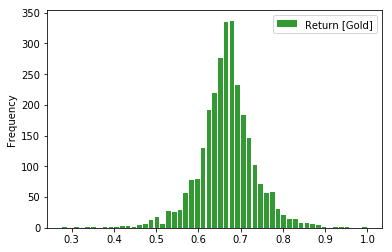

In [157]:
df.plot.hist(bins=int(np.sqrt(len(df))),rwidth=0.8,alpha=0.8,color='g')
plt.show()

Look at the outliers:

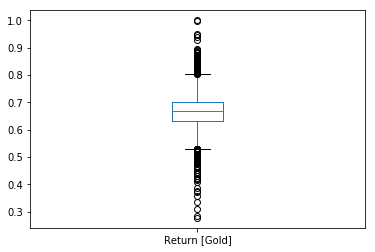

In [158]:
df.boxplot(grid=False) 
plt.show()

Create visual representation. Two ranges of are added:

In [159]:
description=df.describe()

mean=float(description.iloc[1])
std=float(description.iloc[2])

sct=[1,3] #sigma range

u1=round(mean+sct[0]*std,2)
u2=round(mean+sct[1]*std,2)

l1=round(mean-sct[0]*std,2)
l2=round(mean-sct[1]*std,2)

Create figure.Recent point is marked by 'bold':

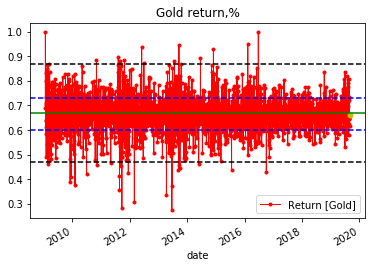

In [160]:
df.plot(color='r',marker='o',linewidth=1, markersize=3)
plt.plot(df.index[-1], df.values[-1],'oy',markersize=5)

plt.axhline(y=mean,color='g',linestyle='-')
plt.axhline(y=u1,color='b',linestyle='--')
plt.axhline(y=l1,color='b',linestyle='--')
plt.axhline(y=u2,color='black',linestyle='--')
plt.axhline(y=l2,color='black',linestyle='--')

plt.title('Gold return,%')
plt.show()

Check return for stationarity by ADF test: 

In [161]:
z=df['Return [Gold]'].values
result=adfuller(z)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -54.167901
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


We can reject the null hypothesis - strongly negative ADF statistic. We may define the average mean reversion time in the frame of ARIMA. Define differences of relative returns (price acceleration) and shift first time series:

In [162]:
df['Difference']=df['Return [Gold]'].diff() 
df['Return [Gold]']=df['Return [Gold]'].shift(1,axis = 0)
df['Return [Gold]']=df['Return [Gold]']-df['Return [Gold]'].mean()
df=df.dropna()

Show Person correlation and significance of H0 hypothesis:

In [163]:
pc=sc.stats.pearsonr(list(df['Return [Gold]']),list(df['Difference']))
print('Gold vs Silver return correlation (Pearson):',round(pc[0],2))
print('Gold vs Silver return 2-tailed p-value:',round(pc[1],2))

Gold vs Silver return correlation (Pearson): -0.71
Gold vs Silver return 2-tailed p-value: 0.0


Scatter plot:

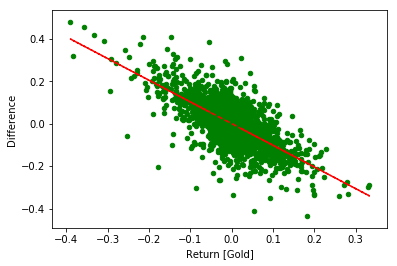

Slope: -1.02
Intercept: -0.0


In [164]:
df.plot.scatter(x='Return [Gold]',y='Difference',color='g') 

x=list(df['Return [Gold]'])
y=list(df['Difference'])

z=np.polyfit(x,y,1)
p=np.poly1d(z)

plt.plot(x,p(x),"r--")
plt.show()

print('Slope:',round(p[1],2))
print('Intercept:',round(p[0],2))

Calcultation of mean reversion decay time. It is the recommended time of long-short position hold:

In [165]:
print('Mean reversion time:',int(round(-math.log(2)/list(z)[0])),'day')

Mean reversion time: 1 day
